In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

p = [1,2,3,5,7,11,13,17,19,23,29,31,37,39,41,43,47,49]

def get_map_cost_3D(piece_map):
    #print(piece_map)
    map_cost = [1,1,1]
    if len(piece_map) >= 3:
        for i in range(1,len(piece_map)-1):
            for j in range(len(piece_map[0])):
                for k in range(len(piece_map[0][0])):
                    #map_cost[0] += p[piece_map[i-1][j][k]+piece_map[i][j][k]] * p[piece_map[i][j][k]+piece_map[i+1][j][k]] * p[piece_map[i][j][k]]
                    map_cost[0] += (piece_map[i-1][j][k]+piece_map[i][j][k]+1) * (piece_map[i][j][k]+piece_map[i+1][j][k]+1) * (piece_map[i][j][k]+1)
    elif len(piece_map) == 2:
        for j in range(len(piece_map[0])):
            for k in range(len(piece_map[0][0])):
                map_cost[0] += p[int(piece_map[0][j][k])]*p[int(piece_map[1][j][k])]
    
    if len(piece_map[0]) >= 3:
        for i in range(len(piece_map)):
            for j in range(1,len(piece_map[0])-1):
                for k in range(len(piece_map[0][0])):
                    #map_cost[1] += p[piece_map[i][j-1][k]+piece_map[i][j][k]] * p[piece_map[i][j][k]+piece_map[i][j+1][k]] * p[piece_map[i][j][k]]
                    map_cost[1] += (piece_map[i][j-1][k]+piece_map[i][j][k]+1) * (piece_map[i][j][k]+piece_map[i][j+1][k]+1) * (piece_map[i][j][k]+1)
    elif len(piece_map[0]) == 2:
        for i in range(len(piece_map)):
            for k in range(len(piece_map[0][0])):
                map_cost[1] += p[int(piece_map[i][0][k])]*p[int(piece_map[i][1][k])]
    
    if len(piece_map[0][0]) >= 3:
        for i in range(len(piece_map)):
            for j in range(len(piece_map[0])):
                for k in range(1,len(piece_map[0][0])-1):
                    #map_cost[2] += p[piece_map[i][j][k-1]+piece_map[i][j][k]] * p[piece_map[i][j][k]+piece_map[i][j][k+1]] * p[piece_map[i][j][k]]
                    map_cost[2] += (piece_map[i][j][k-1]+piece_map[i][j][k]+1) * (piece_map[i][j][k]+piece_map[i][j][k+1]+1) * (piece_map[i][j][k]+1)
    elif len(piece_map[0][0]) == 2:
        for i in range(len(piece_map)):
            for j in range(len(piece_map[0])):
                map_cost[2] += p[int(piece_map[i][j][0])]*p[int(piece_map[i][j][1])]
    
    return map_cost[0] * map_cost[1] * map_cost[2]

In [5]:
class Error():
    def __init__(self, msg):
        print(msg)


class all_piece():
    def __init__(self, shape=None):
        self.shape = shape
        self.piece_list = []
        self.piece_dim = []
        self.piece_size = []
        self.piece_number = []
        self.forbidden_places = [] #[piece_id][pos] = rotation if curr_rot != rot > not autorized
        self.depth_to_id = []
        self.depth_to_number = []
        self.solution_list = []
        self.total_solution = 0
        self.color_list = ["#FF0000CC", "#00FF00CC", "#0000FFCC", "#FF00FFCC", \
                           "#FFFF00CC", "#00FFFFCC", "#000000CC", "#FFFFFFCC", \
                           "#888888CC", "#444444CC", "#BBBBBBCC"]
    
    def print_3D(self, piece_map, view_3D=False):
        if (view_3D == 1):
            %matplotlib notebook
        else:
            %matplotlib inline
        piece_map = self.rotate(piece_map, "l")
        
        x, y, z = np.indices(self.shape)
        voxels = (piece_map != 0)
        #print(voxels)
        colors = np.empty(voxels.shape, dtype=object)
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    value = int(piece_map[i,j,k])
                    if value > 0:
                        colors[i,j,k] = self.color_list[value - 1]
        
        fig = plt.figure(figsize=(2,2))
        ax = fig.gca(projection='3d')
        ax.voxels(voxels, facecolors=colors, edgecolor='k')
        plt.show()
    
    def is_same_piece(self, piece, cmpr):
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    if (piece[i][j][k] == 0 and cmpr[i][j][k] != 0) or (piece[i][j][k] != 0 and cmpr[i][j][k] == 0):
                        return 0
        return 1
    
    def is_exist(self, piece, piece_list):
        for i in piece_list:
            if self.is_same_piece(piece, i) == 1:
                return 1
        return 0
    
    def get_dim(self, piece):
        dim = [0,0,0]
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    if piece[i,j,k] != 0:
                        if dim[0] < i:
                            dim[0] = i
                        if dim[1] < j:
                            dim[1] = j
                        if dim[2] < k:
                            dim[2] = k
        return dim

    def get_size(self, piece):
        size = 0
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    size += (piece[i,j,k] != 0)
        return size
    
    def get_piece_map(self, piece_id, rotation=0):
        return self.piece_list[piece_id][rotation]
    
    def replace_piece(self, piece):
        fix_pos = []
        min_pos = np.array((self.shape[0],self.shape[1],self.shape[2]))
        piece_val = 0
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    if piece[i,j,k] != 0:
                        piece_val = piece[i,j,k]
                        piece[i,j,k] = 0
                        fix_pos.append([i,j,k])
                        if min_pos[0] > i:
                            min_pos[0] = i
                        if min_pos[1] > j:
                            min_pos[1] = j
                        if min_pos[2] > k:
                            min_pos[2] = k
        for i in fix_pos:
            piece[i[0] - min_pos[0], i[1] - min_pos[1], i[2] - min_pos[2]] = piece_val
        return piece

    def rotate(self, piece, rotate_code):
        for i in rotate_code:
            if i == "r":
                piece = np.rot90(piece,  1, (0,1))
            if i == "l":
                piece = np.rot90(piece, -1, (0,1))
            if i == "b":
                piece = np.rot90(piece,  1, (0,2))
            if i == "f":
                piece = np.rot90(piece, -1, (0,2))
            if i == "d":
                piece = np.rot90(piece,  1, (1,2))
            if i == "u":
                piece = np.rot90(piece, -1, (1,2))
        return np.copy(piece)

    def gen_piece(self, piece):
        piece_list = []
        self.piece_dim.append([])
        self.piece_size.append([])
        self.piece_size[-1].append(self.get_size(piece))
        map_cost_ref = get_map_cost_3D(piece)
        #print("map_cost ref :", map_cost_ref)
        code_faces = "fulful"
        code_490rot = "ulfulf"
        for i in range(6):
            for j in range(4):
                test_piece = self.replace_piece(piece)
                #print(get_map_cost_3D(test_piece))
                if self.is_exist(test_piece, piece_list) == 0:
                    piece_list.append(test_piece)
                    self.piece_dim[-1].append(self.get_dim(test_piece))
                piece = self.rotate(piece, code_490rot[i])
            piece = self.rotate(piece, code_faces[i])
        return piece_list

    def to_numpy(self, piece):
        if type(piece) != type(np.array([])):
            piece = np.asarray(piece)
        if len(piece.shape) > 3:
            raise Error("Dimension of piece is > 3")
        for i in range(len(piece.shape)):
            if piece.shape[i] > self.shape[i]:
                raise Error("Dimension in piece.shape is > puzzle.shape")
        res = np.zeros(self.shape)
        if len(piece.shape) == 0:
            res[0,0,0] = 1
            return res
        cursor = [0,0,0]
        for idx, i in enumerate(piece):
            cursor[0] = idx
            try:
                i[0]
            except (TypeError, IndexError):
                res[cursor[0], cursor[1], cursor[2]] = i
            else:
                for jdx, j in enumerate(i):
                    cursor[1] = jdx
                    try:
                        j[0]
                    except (TypeError, IndexError):
                        res[cursor[0], cursor[1], cursor[2]] = j
                    else:
                        for kdx, k in enumerate(j):
                            cursor[2] = kdx
                            res[cursor[0], cursor[1], cursor[2]] = k
        res[res != 0] = 1
        return res
    
    def add_piece(self, piece, number=1):
        if self.shape == None:
            raise Error('Define the shape of the puzzle first')
        if type(number) != type(0):
            raise Error('number of piece is not int')
        if number < 1:
            raise Error('number cannot be less than 1')
        piece = self.to_numpy(piece)
        self.piece_number.append(number)
        self.piece_list.append(self.gen_piece(piece))

    def print_all(self, piece_id=-1):
        for idx, i in enumerate(self.piece_list):
            print("piece", idx, " size :", self.piece_size[idx][0], \
                " rotation :", len(self.piece_list[idx]), " copies :", self.piece_number[idx], \
                " map cost :", get_map_cost_3D(self.piece_list[idx][0]))
            self.print_3D(i[0])
            print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
            #print("dim :", self.piece_dim[idx][0])

    def watch_solution(self, display_type=None):
        print("Number of solutions :", len(self.solution_list))
        if display_type != None:
            for i in self.solution_list:
                self.print_3D(i)
                print(get_map_cost_3D(i))

    def is_solvable(self):
        space = self.shape[0] * self.shape[1] * self.shape[2]
        piece_space = 0
        for i in range(len(self.piece_list)):
            piece_space += self.piece_size[i][0] * self.piece_number[i]
            
        if piece_space == space:
            return 1
        if piece_space < space:
            print("The amount of space taken by pieces is too low to fill the puzzle")
            print("Change and/or add pieces")
        else:
            print("The amount of space taken by pieces is too high to fill the puzzle")
            print("Change and/or remove pieces")
        print("Space to fill :", space, "  Space of all pieces :", piece_space)
        return 0

    def is_placeable(self, pos, piece_map, piece):        
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    if piece[i,j,k] != 0 and piece_map[i+pos[0], j+pos[1], k+pos[2]] != 0:
                        return 0
        return 1
    
    def is_allowed(self, i,j,k, piece_id, piece_rotation_id):
        print(piece_rotation_id)
        if self.piece_number[piece_id] == 1:
            return 1
        val = self.forbidden_places[piece_id][piece_rotation_id][i,j,k]
        #print(val, piece_rotation_id)
        if val == 1:
            for x in range(len(self.forbidden_places[piece_id])):
                self.forbidden_places[piece_id][x][i,j,k] = (x == piece_rotation_id)
            return 1
        return 0

    def place_piece(self, pos, piece_map, piece, piece_value):
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    if piece[i,j,k] != 0:
                        piece_map[i+pos[0], j+pos[1], k+pos[2]] = piece_value
        return piece_map
    
    def recursive(self, piece_map, depth=0):
        if self.total_solution > 3:
                return
        piece_id = self.depth_to_id[depth]
        if piece_id == len(self.piece_list):
            self.solution_list.append(piece_map)
            self.total_solution += 1
            print(self.total_solution)
            #print(piece_map)
            return
        for idx, piece_rotation in enumerate(self.piece_list[piece_id]):
            for i in range(self.shape[0] - self.piece_dim[piece_id][idx][0]):
                for j in range(self.shape[1] - self.piece_dim[piece_id][idx][1]):
                    for k in range(self.shape[2] - self.piece_dim[piece_id][idx][2]):
                        #print(depth, idx, i, j, k)
                        if self.is_placeable((i,j,k), piece_map, piece_rotation) == 1:
                            \
self.recursive(self.place_piece((i,j,k), np.copy(piece_map), piece_rotation, depth + 1), depth + 1)
    
    def recursive_test(self, piece_map, depth=0):
        piece_id = self.depth_to_id[depth]
        piece_numeral = self.depth_to_number[depth]
        if piece_id == len(self.piece_list):
            self.solution_list.append(piece_map)
            self.total_solution += 1
            #print(self.total_solution)
            #print(piece_map)
            return
        for idx, piece_rotation in enumerate(self.piece_list[piece_id]):
            for i in range(self.shape[0] - self.piece_dim[piece_id][idx][0]):
                for j in range(self.shape[1] - self.piece_dim[piece_id][idx][1]):
                    for k in range(self.shape[2] - self.piece_dim[piece_id][idx][2]):
                        #print(depth, idx, i, j, k)
                        if self.is_placeable((i,j,k), piece_map, piece_rotation) == 1 and \
                        self.is_allowed(i,j,k, piece_id, depth) == 1: \
self.recursive_test(self.place_piece((i,j,k), np.copy(piece_map), piece_rotation, depth + 1), depth + 1)
    
    def init_forbidden(self):
        self.forbidden_places = []
        for idx, piece in enumerate(self.piece_list):
            if self.piece_number[idx] == 1:
                self.forbidden_places.append([0])
            else:
                self.forbidden_places.append([])            
                for id_piece in self.piece_number[idx]:
                    self.forbidden_places[idx].append(np.ones(self.shape))
    
    def solve(self, solve_type=None):
        if len(self.solution_list) > 0:
            self.solution_list = []
        if self.is_solvable() == 0:
            return
        
        self.depth_to_id = []
        self.depth_to_number = [0]
        for idx, i in enumerate(self.piece_number):
            for j in range(i):
                self.depth_to_id.append(idx)
        self.depth_to_id.append(len(self.piece_list))
        
        for i in range(1, len(self.depth_to_id)):
            if self.depth_to_id[i-1] == self.depth_to_id[i]:
                self.depth_to_number.append(self.depth_to_number[i-1] + 1)
            else:
                self.depth_to_number.append(0)
                
        self.depth_to_number.append(0)
        
        print("depth to id >", self.depth_to_id)
        
        
        self.total_solution = 0
        #self.init_forbidden()
        if solve_type == None:
            self.recursive(np.zeros(self.shape))
        else:
            self.recursive_test(np.zeros(self.shape))

piece 0  size : 4  rotation : 24  copies : 4  map cost : 9016.0


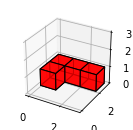

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
piece 1  size : 3  rotation : 12  copies : 1  map cost : 6292.0


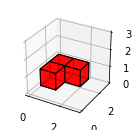

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
piece 2  size : 4  rotation : 12  copies : 1  map cost : 10948.0


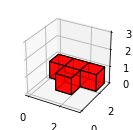

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
piece 3  size : 4  rotation : 12  copies : 1  map cost : 12992.0


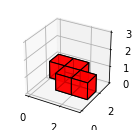

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [6]:
dtb = all_piece((3,3,3))
piece_tL  = [[1,1],[1]]
piece_sqr = [[1,1],[1,1]]
piece_I  = [1,1]
piece_1 = 1
piece_T = [[1,1,1],[0,1,0]]
piece_Z = [[1,1],[0,1,1]]
piece_L = [[1,1,1],[1]]

test = [[[1,1],[1,0]],[[1,0],[0,0]]]

dtb.add_piece(piece_L,4)
dtb.add_piece(piece_tL)
dtb.add_piece(piece_T)
dtb.add_piece(piece_Z)

#dtb.print_3D([[[2,2],[1,1]],[[3,3],[3,1]]], True)
dtb.print_all()

depth to id > [0, 0, 0, 0, 1, 2, 3, 4]
1
2
3
Number of solutions : 3


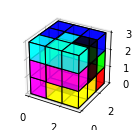

170407986672.0


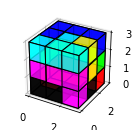

110176704936.0


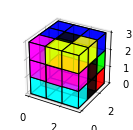

167576074848.0


In [7]:
dtb.solve()
dtb.watch_solution("ui")